Date: 30Nov2022

Author: Lynn Menchaca

Resources:
- Youtube channel: codebasics -> Data Science Project|Machine Learning Project|Sports Celebrity Image Classification
    https://www.youtube.com/playlist?list=PLeo1K3hjS3uvaRHZLl-jLovIjBP14QTXc
- Youtube channel: Learn Code By Gaming -> Training a Cascade classifier - OpenCV Object Detection in Games #8
    https://www.youtube.com/watch?v=XrCAvs9AePM
- to find images: image-net.org
- OpenCV-Python Tutorials -> Face Detection using Haar Cascades
    https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

Manually cleaned non simpson characters from each folder

In [192]:
import pandas as pd
import numpy as np
import seaborn as sn
import os
import pywt
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

#Model imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import joblib #creates pickel file
import json

In [2]:
#Trying to see what version of cv2 is being used
print(cv2.__version__)

4.6.0


In [3]:
#This project is in two different folders:
#Data -> Data_Files folder: simpson jpeg images, the haar cascades xml files
#        and face identified simpson images process with opencv executable on windows computer
#Code -> Simpson_Classifier folder

image_file_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/'
pos_file_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/positive/'

In [4]:
#pulling the first Homer Simpson image
homer_simp = image_file_path+'homer_simpson/22.jpg'
img = cv2.imread(homer_simp)
img.shape

(1050, 1400, 3)

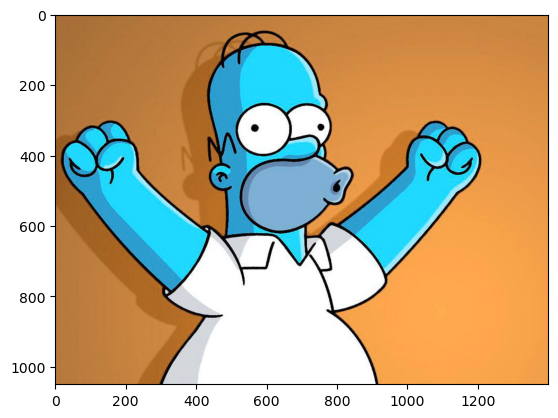

In [5]:
plt.imshow(img)

shape:  (1050, 1400)


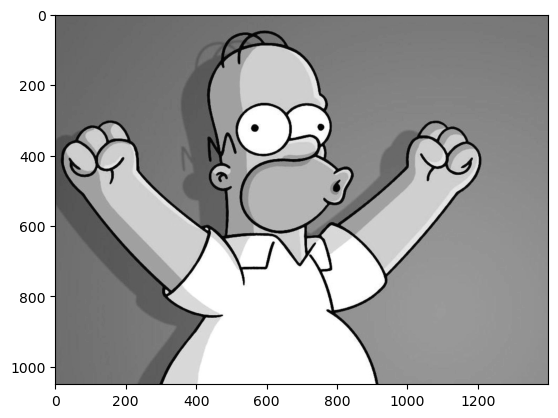

In [6]:
#black and white of image
homer_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#if need to resize
#homer_gray = cv2.resize(homer_gray, (1000,1000))
#shape
print('shape: ', homer_gray.shape)
#array
homer_gray
#image
plt.imshow(homer_gray, cmap='gray')

---

Since I am using cartoon images not human face I could not use the haar cascades xml files to correctly identify Simpson character face in each image. I used the opencv executable on a windows computer to manually identify each face.

---

In [7]:
# cleaning the positive data files created identifying the location of each face on the image.
# while transfering text data to a data frame all rows with multiple images identified were dropped.

bart_df = pd.read_csv(pos_file_path+'pos_bart.txt', sep=" ", header=None, on_bad_lines='skip')
bart_df.columns = ["path", "char_count", "x", "y", "width", "height"]
bart_df.head()

,path,char_count,x,y,width,height
0,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,79.0,4.0,107.0,117.0
1,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,58.0,39.0,98.0,108.0
2,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,283.0,3.0,260.0,374.0
3,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,65.0,0.0,110.0,130.0
4,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,81.0,14.0,66.0,90.0


In [8]:
bart_df[bart_df['char_count']==0]

,path,char_count,x,y,width,height
7,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,0,NaN,NaN,NaN,NaN
10,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,0,NaN,NaN,NaN,NaN
12,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,0,NaN,NaN,NaN,NaN
14,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,0,NaN,NaN,NaN,NaN
28,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,0,NaN,NaN,NaN,NaN
40,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,0,NaN,NaN,NaN,NaN


In [9]:
# drop all the rows with 0 characters identified in the photo

bart_zero_idx = bart_df[bart_df['char_count']==0].index
bart_df.drop(bart_zero_idx, inplace=True)
bart_df.reset_index(drop=True,inplace=True)
#bart_df[bart_df['char_count']==0].head()
print(bart_df.shape)
bart_df.head()

(42, 6)


,path,char_count,x,y,width,height
0,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,79.0,4.0,107.0,117.0
1,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,58.0,39.0,98.0,108.0
2,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,283.0,3.0,260.0,374.0
3,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,65.0,0.0,110.0,130.0
4,C:/Users/ymenc/OneDrive/Desktop/Simpson_Images...,1,81.0,14.0,66.0,90.0


In [10]:
print(bart_df.dtypes)
pd.options.display.max_colwidth = 100
#pd.set_options('display.max_colwidth', -1)
bart_df['path'].head()

path           object
char_count      int64
x             float64
y             float64
width         float64
height        float64
dtype: object


0      C:/Users/ymenc/OneDrive/Desktop/Simpson_Images/bart_simpson\1.jpg
1    C:/Users/ymenc/OneDrive/Desktop/Simpson_Images/bart_simpson\105.jpg
2    C:/Users/ymenc/OneDrive/Desktop/Simpson_Images/bart_simpson\106.jpg
3    C:/Users/ymenc/OneDrive/Desktop/Simpson_Images/bart_simpson\107.jpg
4    C:/Users/ymenc/OneDrive/Desktop/Simpson_Images/bart_simpson\108.jpg
Name: path, dtype: object

In [11]:
#correct file path to point to images on desktop
old_path = 'C:/Users/ymenc/OneDrive/Desktop/'
new_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/'
bart_df['path'] = bart_df['path'].str.replace(r'\\','/', regex=True)
bart_df['path'] = bart_df['path'].str.replace(old_path,new_path, regex=True)

bart_df['path'].head()

0      /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/bart_simpson/1.jpg
1    /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/bart_simpson/105.jpg
2    /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/bart_simpson/106.jpg
3    /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/bart_simpson/107.jpg
4    /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/bart_simpson/108.jpg
Name: path, dtype: object

In [82]:
# Homer
homer_df = pd.read_csv(pos_file_path+'pos_homer.txt', sep=" ", header=None, on_bad_lines='skip')
homer_df.columns = ["path", "char_count", "x", "y", "width", "height"]

# drop all the rows with 0 characters identified in the photo
homer_zero_idx = homer_df[homer_df['char_count']==0].index
homer_df.drop(homer_zero_idx, inplace=True)
homer_df.reset_index(drop=True,inplace=True)
homer_df['path'] = homer_df['path'].str.replace(r'\\','/', regex=True)
homer_df['path'] = homer_df['path'].str.replace(old_path,new_path, regex=True)
print(homer_df.shape)
homer_df.head(10)

(78, 6)


,path,char_count,x,y,width,height
0,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/1.jpg,1,821.0,260.0,241.0,235.0
1,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/100.jpg,1,259.0,0.0,292.0,379.0
2,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/102.jpg,1,129.0,6.0,63.0,67.0
3,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/104.jpg,1,28.0,7.0,75.0,96.0
4,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/106.jpg,1,337.0,15.0,464.0,673.0
5,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/107.jpg,1,21.0,82.0,73.0,63.0
6,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/108.jpg,1,123.0,20.0,54.0,55.0
7,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/109.jpg,1,27.0,4.0,99.0,72.0
8,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/11.jpg,1,121.0,20.0,44.0,74.0
9,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/111.jpg,1,114.0,25.0,81.0,106.0


In [13]:
# Lisa
lisa_df = pd.read_csv(pos_file_path+'pos_lisa.txt', sep=" ", header=None, on_bad_lines='skip')
lisa_df.columns = ["path", "char_count", "x", "y", "width", "height"]

# drop all the rows with 0 characters identified in the photo
lisa_zero_idx = lisa_df[lisa_df['char_count']==0].index
lisa_df.drop(lisa_zero_idx, inplace=True)
lisa_df.reset_index(drop=True,inplace=True)
lisa_df['path'] = lisa_df['path'].str.replace(r'\\','/', regex=True)
lisa_df['path'] = lisa_df['path'].str.replace(old_path,new_path, regex=True)
print(lisa_df.shape)
lisa_df.head()

(74, 6)


,path,char_count,x,y,width,height
0,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/lisa_simpson/100.jpg,1,246.0,23.0,241.0,251.0
1,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/lisa_simpson/101.jpg,1,57.0,2.0,318.0,256.0
2,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/lisa_simpson/103.jpg,1,101.0,0.0,120.0,122.0
3,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/lisa_simpson/105.jpg,1,98.0,11.0,105.0,123.0
4,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/lisa_simpson/106.jpg,1,1.0,1.0,498.0,449.0


In [14]:
# Maggie
maggie_df = pd.read_csv(pos_file_path+'pos_maggie.txt', sep=" ", header=None, on_bad_lines='skip')
maggie_df.columns = ["path", "char_count", "x", "y", "width", "height"]

# drop all the rows with 0 characters identified in the photo
maggie_zero_idx = maggie_df[maggie_df['char_count']==0].index
maggie_df.drop(maggie_zero_idx, inplace=True)
maggie_df.reset_index(drop=True,inplace=True)
maggie_df['path'] = maggie_df['path'].str.replace(r'\\','/', regex=True)
maggie_df['path'] = maggie_df['path'].str.replace(old_path,new_path, regex=True)
print(maggie_df.shape)
maggie_df.head()

(77, 6)


,path,char_count,x,y,width,height
0,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/maggie_simpson/1.jpg,1,35.0,4.0,144.0,131.0
1,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/maggie_simpson/100.jpg,1,141.0,4.0,154.0,156.0
2,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/maggie_simpson/101.jpg,1,1.0,4.0,180.0,170.0
3,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/maggie_simpson/102.jpg,1,27.0,11.0,108.0,91.0
4,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/maggie_simpson/103.jpg,1,65.0,5.0,140.0,100.0


In [129]:
# Marge
marge_df = pd.read_csv(pos_file_path+'pos_marge.txt', sep=" ", header=None, on_bad_lines='skip')
marge_df.columns = ["path", "char_count", "x", "y", "width", "height"]

# drop all the rows with 0 characters identified in the photo
marge_zero_idx = marge_df[marge_df['char_count']==0].index
marge_df.drop(marge_zero_idx, inplace=True)
marge_df.reset_index(drop=True,inplace=True)
marge_df['path'] = marge_df['path'].str.replace(r'\\','/', regex=True)
marge_df['path'] = marge_df['path'].str.replace(old_path,new_path, regex=True)
print(marge_df.shape)
marge_df.head()

(67, 6)


,path,char_count,x,y,width,height
0,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/marge_simpson/10.jpg,1,126.0,35.0,215.0,338.0
1,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/marge_simpson/100.jpg,1,49.0,39.0,122.0,132.0
2,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/marge_simpson/102.jpg,1,917.0,35.0,308.0,407.0
3,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/marge_simpson/103.jpg,1,61.0,2.0,66.0,73.0
4,/Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/marge_simpson/105.jpg,1,112.0,3.0,61.0,110.0


In [54]:
#looking at first data row for homer simpson
homer_df.iloc[1]

path          /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/homer_simpson/100.jpg
char_count                                                                                          1
x                                                                                               259.0
y                                                                                                 0.0
width                                                                                           292.0
height                                                                                          379.0
Name: 1, dtype: object

(683, 1200, 3)


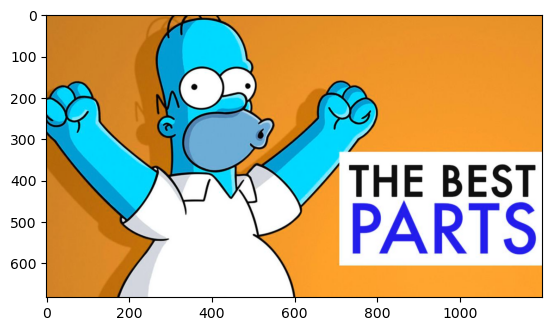

In [55]:
#pulling the first Homer Simpson image
homer_simp = homer_df['path'].iloc[1]
img = cv2.imread(homer_simp)
print(img.shape)
plt.imshow(img)

In [60]:
#need to make the values integers to work with cv2
face_col = ['x', 'y', 'width', 'height']
face = homer_df[face_col].iloc[1].astype(int).tolist()
(x,y,w,h) = face
x,y,w,h

(259, 0, 292, 379)

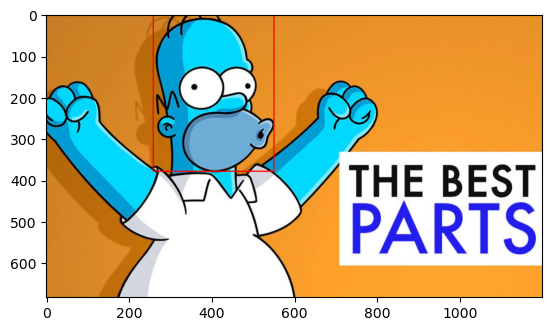

In [57]:
#cv2.rectangle(image, start point, end point, color(r,g,b), line thickness)
homer_face = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
plt.imshow(homer_face)

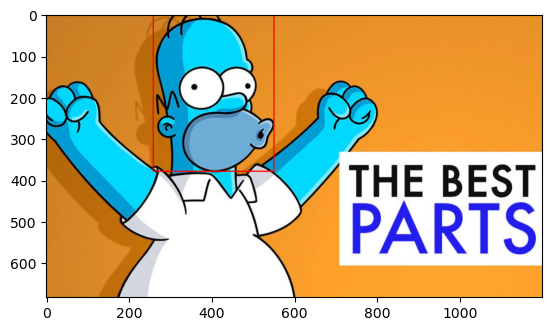

In [58]:
# from OpenCV-Python Tutorials -> Face Detection using Haar Cascades
# For loop used to detect the eyes
cascades_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/haarcascades/'
face_cascade = cv2.CascadeClassifier(cascades_path+'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path+'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2.destroyAllWindows()
for (x,y,w,h) in [face]:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.figure()
plt.imshow(homer_face, cmap='gray')
plt.show()

Since this is a cartoon image not a human face the eyes haar cascades algorythm for opencv does not work.

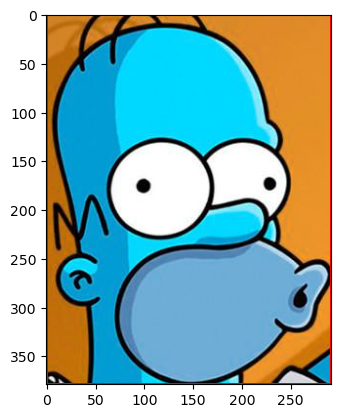

In [59]:
#just the cropped face
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [62]:
homer_df.shape[0]

78

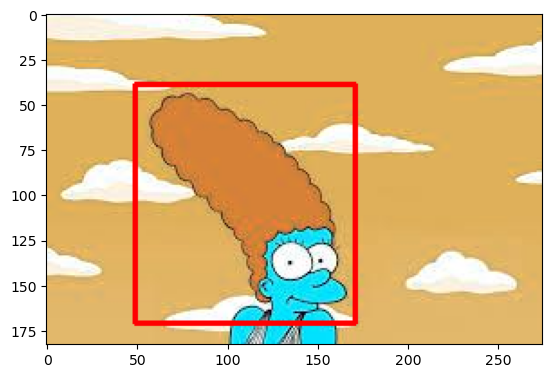

In [135]:
#troubleshooting marge simpson
#problem was folder was pointing to homer photos

photo_loc = marge_df['path'].iloc[1]
img = cv2.imread(photo_loc)
face = marge_df[face_col].iloc[1].astype(int).tolist()
(x,y,w,h) = face
#print(face)
    
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(face_img)

In [131]:
#noticing all photos with multiple faces identified were dropped for each character.

print('Bart: ', bart_df['char_count'].value_counts())
print('Homer: ',homer_df['char_count'].value_counts())
print('Lisa: ',lisa_df['char_count'].value_counts())
print('Maggie: ',maggie_df['char_count'].value_counts())
print('Marge: ',marge_df['char_count'].value_counts())

Bart:  1    42
Name: char_count, dtype: int64
Homer:  1    78
Name: char_count, dtype: int64
Lisa:  1    74
Name: char_count, dtype: int64
Maggie:  1    77
Name: char_count, dtype: int64
Marge:  1    67
Name: char_count, dtype: int64


In [139]:
#Function to go though each row of a data frame
#Take the crop image of photo and put in new file

eye_cascade = cv2.CascadeClassifier(cascades_path+'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
photo = homer_df['path'].iloc[1]
face_col = ['x', 'y', 'width', 'height']

def cropped_img_file(df, name):
    # loop through each row
    # pull the image file and cordinates for the identified character face
    #df.shape[0]
    
    #roi_gray = []
    #roi_color = []
    count = 0
    cropped_image_dirs = []
    crop_file_dict = {}
    crop_file_dict[name] = []
    
    for i in range(0,df.shape[0]):
        #count = 0
        #char_file_name_dict[name] = []
        photo_loc = df['path'].iloc[i]
        img = cv2.imread(photo_loc)
        face = df[face_col].iloc[i].astype(int).tolist()
        (x,y,w,h) = face
        #print(face)
    
        face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray_lst = gray[y:y+h, x:x+w]
        roi_color_lst = face_img[y:y+h, x:x+w]
        #print(roi_color_lst)
        #roi_gray.append(roi_gray_lst)
        #roi_color.append(roi_color_lst)
        
        cropped_folder = image_file_path + 'cropped/' + name
        if not os.path.exists(cropped_folder):
            os.makedirs(cropped_folder)
            cropped_image_dirs.append(cropped_folder)
            print("Generating cropped images in folder: ",cropped_folder)
        
        cropped_file_name = name + str(count) + ".jpg"
        cropped_file_path = cropped_folder + "/" + cropped_file_name
        cv2.imwrite(cropped_file_path, roi_color_lst)
        crop_file_dict[name].append(cropped_file_path)
        count += 1
            
    return crop_file_dict

In [140]:
crop_file_dict = {}
crop_file_dict.update(cropped_img_file(homer_df, 'homer'))
crop_file_dict.update(cropped_img_file(bart_df, 'bart'))
crop_file_dict.update(cropped_img_file(lisa_df, 'lisa'))
crop_file_dict.update(cropped_img_file(maggie_df, 'maggie'))
crop_file_dict.update(cropped_img_file(marge_df, 'marge'))
#char_file_name_dict

Generating cropped images in folder:  /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/cropped/homer
Generating cropped images in folder:  /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/cropped/bart
Generating cropped images in folder:  /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/cropped/lisa
Generating cropped images in folder:  /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/cropped/maggie
Generating cropped images in folder:  /Users/lynnpowell/Documents/DS_Projects/Data_Files/Simpson_Images/cropped/marge


In [136]:
#function to conver image to a wavelet transformed image
#source: Youtube channel: codebasics

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

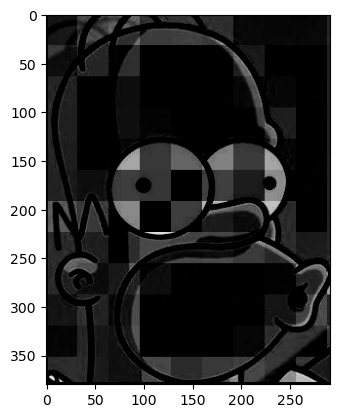

In [138]:
# The wavelet transformed image
#this will help the classifier identify common light and dark features of each face identified character


cropped_img = roi_color

im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

---

Manually clean all photos that would not be good training data or any unwanted photos from each cropped folder.

---


In [142]:
#assinging an integer value to each simpson character
#this will be used as my output variable

char_dict = {}
count = 0
for char_name in crop_file_dict.keys():
    char_dict[char_name] = count
    count += 1
    
char_dict

{'homer': 0, 'bart': 1, 'lisa': 2, 'maggie': 3, 'marge': 4}

In [148]:
# creating a loop to go through each cropped image in our dictionary for each character

#independent features
X = []
#y is the output (simpson character name)
#y will be an integer value assigned to each character name -> dict above
y = []

for char_name, train_files in crop_file_dict.items():
    for train_img in train_files:
        img = cv2.imread(train_img)
        
        #when manually cleaning images out of the folder it leaves a blank placeholder
        #used to skip that train_img file when the image is not present
        if img is None:
            continue
        
        #scale images to a uniform size
        scalled_raw_img = cv2.resize(img, (32,32))
        #wavelet transformed image
        img_har = w2d(img, 'db1', 5)
        #scale images to a uniform size
        scalled_img_har = cv2.resize(img_har, (32,32))
        #stacking images using numpy
        combine_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
        
        
        X.append(combine_img)
        y.append(char_dict[char_name])
        



In [156]:
print('x row lenght: ', len(X[0]))
print('raw image and wavelet image: ', 32*32*3 + 32*32)

x row lenght:  4096
raw image and wavelet image:  4096


In [154]:
# looking at first row

X[0]

array([[208],
       [197],
       [172],
       ...,
       [  0],
       [  0],
       [  0]], dtype=uint8)

In [155]:
#simpson character index
y[0]

0

In [159]:
# 

X = np.array(X).reshape(len(X),4096).astype(float)
print(X.shape)
X[0]

(338, 4096)


array([208., 197., 172., ...,   0.,   0.,   0.])

---

### Model Training

- Support Vector Machine (SVM) using rbf kernel tuned with heuristic finetuning
- Random Forest
- Logistic Regression
- Use Hyperperameter turning

---

In [172]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [173]:
#creating pipeline: scaling the data first, then creating SVC model with arbitrary parameters

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8941176470588236

In [174]:
print('Number in train: ', len(X_train))
print('Number in test: ', len(X_test))

Number in train:  253
Number in test:  85


This model has a 89.41% accuracy. Not sure yet if that is due to overfitting

In [175]:
#precision: percentage of how many seleced items are relevant
#recall: percentage of how many relevant items are selected
#f1-score = 2 * (precision*recall)/(precision+recall)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       1.00      0.76      0.87        17
           2       0.74      0.88      0.80        16
           3       0.86      0.90      0.88        20
           4       1.00      1.00      1.00        17

    accuracy                           0.89        85
   macro avg       0.91      0.89      0.90        85
weighted avg       0.91      0.89      0.90        85



Trying different models with hyperparameter tuning to see if we can improve accuracy.

In [177]:
#trying different models and parameters

#creating a dictionary with differnt models: SVM, Random Forest, Logistic Regression
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [178]:
scores = []
best_estimators = {}

#for loop for each model defined above
for algo, mp in model_params.items():
    #scale the data then run model
    pipe = make_pipeline(StandardScaler(), mp['model'])
    #hyperparameter tuning - cross validation (5 folds)
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    #add dic to score with model, best score and best parameters
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
#turn scores array in to a data frame
scores_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
scores_df

#to see parameters
#print: best_estimators

,model,best_score,best_params
0,svm,0.849882,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.719686,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.833961,{'logisticregression__C': 1}


---

Based off the scored dataframe the Support Vector Machine (SVM) is the best model with C being 1 and kernel being linear. It stil can be an overfitted model.

---

In [180]:
print('SVM Test Score: ', best_estimators['svm'].score(X_test,y_test))
print('Random Forest Test Score: ', best_estimators['random_forest'].score(X_test,y_test))
print('Logistic Regression Test Score: ', best_estimators['logistic_regression'].score(X_test,y_test))

SVM Test Score:  0.9058823529411765
Random Forest Test Score:  0.6235294117647059
Logistic Regression Test Score:  0.9529411764705882


Based of this data the logistic regression performs the best with the test data set. Some say if the test score provides a better idea of how the model will run in production. Some say the train score (SV score) along with the test score to see what model they should deploy. The SVM has a smaller range between the train and test scores.

In [181]:
# Using SVM model because the range in scores is very close.

best_clf = best_estimators['svm']

[[13  0  2  0  0]
 [ 1 15  1  0  0]
 [ 1  0 14  1  0]
 [ 0  0  2 18  0]
 [ 0  0  0  0 17]]


Text(70.72222222222221, 0.5, 'True')

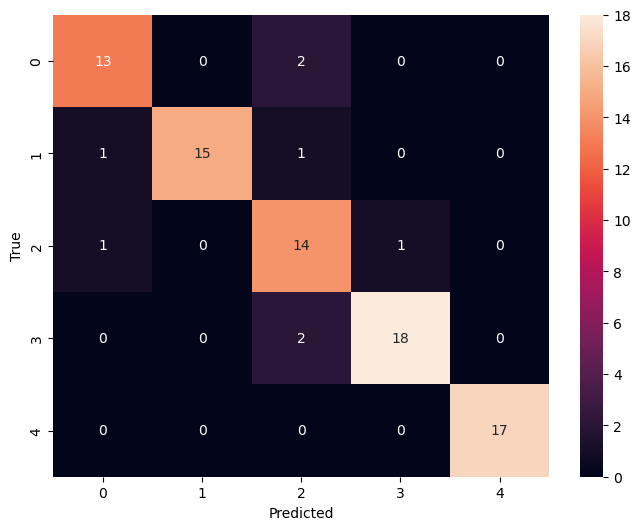

In [189]:
#confusion matrix

cm = confusion_matrix(y_test, best_clf.predict(X_test))
print(cm)

#plot
plt.figure(figsize = (8,6))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

Key: 'homer': 0, 'bart': 1, 'lisa': 2, 'maggie': 3, 'marge': 4

An example of reading the confusion matrix is for Maggie (3) images lisa (2) was predicted twice. Marge has the highest accuracy. I think it is becuase of her blue hair. No other character has blue hair. Bart, Lisa and Maggie both have spiky hair. The difference between Maggie and Lisa is Maggie has a passifier in her mouth (but not in all photos) and Lisa has perals but not in all photos.

In [191]:
#save model as a pickle file
#model will save in the directory this jupyter notebook file is in
joblib.dump(best_clf, 'svm_model.pkl')

['svm_model.pkl']

In [194]:
#save the class dictionary
#the char_dict is the value assinged to y (output)
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(char_dict))

In [195]:
# both files were moved from Simpson_Classifier
# To: Simpson_Classifier -> server -> artifacts